In [1]:
import pegasos
import numpy as np
import pickle
from collections import defaultdict
import pdb
import random
from tqdm import tqdm
from time import time
import matplotlib.pyplot as plt
from scipy import misc
import matplotlib.gridspec as gridspec
import os

# Keras imports
import keras
from keras.models import load_model, Sequential, Model
from keras.layers import Dropout, Dense, Conv2D, Flatten, MaxPooling2D, Activation, Input, LeakyReLU, BatchNormalization
from keras.callbacks import ModelCheckpoint



class SVM_Triplet:
    def __init__(self, X1, X2, Y, base_classes, pos_class, new_class):
        self.X1 = X1
        self.X2 = X2
        self.Y = Y
        self.base_classes = base_classes
        self.pos_class = pos_class
        self.new_class = new_class

def prepare_features(pos_class, neg_classes, feature_vectors, is_train=True, 
                     equal_features=False, train_split=0.9):
    '''
    Returns 4096-dim features for each image which would be used for SVM training
    inputs : 
        is_train -> will return 90% of features for each class if is_train=True, else returns 10% features
        equal_features -> if set to True, then len(neg_features) = len(pos_features)
    
    Returns:
        pos_features -> features of images in the positive class
        neg_features -> features of images in the negative classes
    '''
    
    if is_train:
        num_pos_samples = int(train_split*feature_vectors[pos_class].shape[0])
        pos_features = feature_vectors[pos_class][:num_pos_samples]    # n x 4096
        
        neg_features = []

        for neg_class in neg_classes:
            num_neg_samples = int(train_split*feature_vectors[neg_class].shape[0])
            neg_features.extend(feature_vectors[neg_class][:num_neg_samples])
            
    else:
        num_pos_samples = int(train_split*feature_vectors[pos_class].shape[0])
        pos_features = feature_vectors[pos_class][num_pos_samples:]    # n x 4096
        
        neg_features = []

        for neg_class in neg_classes:
            num_neg_samples = int(train_split*feature_vectors[neg_class].shape[0])
            neg_features.extend(feature_vectors[neg_class][num_neg_samples:])
             
    if equal_features:
        neg_features = np.random.permutation(neg_features)[:pos_features.shape[0]]
    
    return pos_features, neg_features
    
def compute_accuracy(weight_vector, pos_features, neg_features):
    classifier = pegasos.PegasosSVMClassifier()
    classifier.fit(np.zeros((2, 1024)), np.asarray([1, 0]))
    classifier.weight_vector.weights = weight_vector

    # Concat data and pass to SVM
    result = classifier.predict(np.vstack((pos_features, neg_features)))
    ground_truth = np.concatenate((np.ones(len(pos_features)), np.zeros(len(neg_features))))
    return np.average(np.equal(ground_truth, result))

def get_svm_weights(x_train, y_train):
    svm = pegasos.PegasosSVMClassifier()
    svm.fit(x_train, y_train)
    weight_vector = svm.weight_vector.weights
    return weight_vector


def get_x_y(pos_features, neg_features):
    x = np.vstack((pos_features, neg_features))
    y = np.hstack((np.ones( len(pos_features)),
                   np.zeros(len(neg_features))))
    return x, y

'''
SVM for novel class. 
pos_class = pos_class
neg_classes = base_classes - pos_class
'''
def compute_X1(pos_class, base_classes, feature_vectors, is_train=True):
    neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
    pos_features, neg_features = prepare_features(pos_class, neg_classes, feature_vectors, is_train=is_train)
    x_train, y_train = get_x_y(pos_features, neg_features)
    weight_vector = get_svm_weights(x_train, y_train)
    return weight_vector

'''
SVM for novel class. 
pos_class = novel_class
neg_classes = base_classes
'''
def compute_X2(novel_class, base_classes, feature_vectors, is_train=True):
    pos_features, neg_features = prepare_features(novel_class, base_classes, feature_vectors, is_train=is_train)
    x_train, y_train = get_x_y(pos_features, neg_features)
    weight_vector = get_svm_weights(x_train, y_train)
    return weight_vector
    
'''
SVM for pos class under the influence of the neg class. 
pos_class = pos_class
neg_classes = base_classes - pos_class + novel_class
'''
def compute_Y(pos_class, novel_class, base_classes, feature_vectors, is_train=True):
    neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
    neg_classes = np.append(neg_classes, novel_class)
    pos_features, neg_features = prepare_features(pos_class, neg_classes, feature_vectors, is_train=is_train)
    x_train, y_train = get_x_y(pos_features, neg_features)
    weight_vector = get_svm_weights(x_train, y_train)
    return weight_vector

Using TensorFlow backend.


In [2]:
FEATURE_FILE = '/media/red/capstone/data/mit_67/vgg16_features.pickle'
TRIPLETS_FILE = '/media/red/capstone/data/triplets.pkl'

In [3]:
# Load features
# split the classes
# Split the images within each class
features, file_names = pickle.load(open(FEATURE_FILE, "rb"))

seed = 1234
np.random.seed(seed)

# Splitting classes into train/val/test
labels = np.array(list(features.keys()))
perm = np.random.permutation(len(labels))
labels = labels[perm]

splits = {}
splits['base']=labels[:30]
splits['novel'] = labels[30:50]
splits['test']=labels[50:]

print(splits)

{'base': array(['meeting_room', 'inside_bus', 'poolinside', 'inside_subway',
       'casino', 'mall', 'subway', 'dining_room', 'toystore', 'classroom',
       'livingroom', 'laundromat', 'greenhouse', 'airport_inside',
       'computerroom', 'fastfood_restaurant', 'bar', 'bathroom', 'museum',
       'children_room', 'concert_hall', 'lobby', 'grocerystore',
       'shoeshop', 'bedroom', 'gameroom', 'auditorium', 'bakery',
       'restaurant_kitchen', 'movietheater'],
      dtype='<U19'), 'novel': array(['trainstation', 'tv_studio', 'gym', 'garage', 'church_inside',
       'bowling', 'corridor', 'operating_room', 'warehouse', 'stairscase',
       'buffet', 'winecellar', 'kindergarden', 'deli', 'dentaloffice',
       'artstudio', 'hairsalon', 'elevator', 'hospitalroom', 'waitingroom'],
      dtype='<U19'), 'test': array(['clothingstore', 'restaurant', 'prisoncell', 'library', 'nursery',
       'jewelleryshop', 'pantry', 'cloister', 'closet', 'videostore',
       'florist', 'studiomusic', 

### Create triplets for training

In [ ]:
random.seed(1234)
NUM_SIMULATIONS = 100000
triplets = []

for i in tqdm(range(int(NUM_SIMULATIONS/200))):
    base_class_ind = np.random.permutation(len(splits['base']))[:10]
    base_classes = splits['base'][base_class_ind]
    
    X1s = {}
    for pos_class in base_classes:
        X1s[pos_class] = compute_X1(pos_class, base_classes, features)
    
    X2s = {}
    for new_class in splits['novel']:
        X2s[new_class] = compute_X2(new_class, base_classes, features)

    
    # The following code generates 200 triplets - 10 pos classes x 20 novel classes for each pos class
    for pos_class in base_classes:
        X1 = X1s[pos_class]
        for new_class in splits['novel']:
            
            X2 = X2s[new_class]
            Y = compute_Y(pos_class, new_class, base_classes, features)
#             pdb.set_trace()
            
    
    
            # Sanity check
            t1 = time()
#             neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
#             neg_classes_extra = np.append(neg_classes, new_class)
#             pos_features_test, neg_features_test = prepare_features(pos_class, 
#                                                                     neg_classes_extra, 
#                                                                     features, 
#                                                                     is_train=False, 
#                                                                     equal_features=False)
#             acc1 = compute_accuracy(X1, pos_features_test, neg_features_test)
#             acc2 = compute_accuracy(Y, pos_features_test, neg_features_test)
            print (time() - t1)
            
            print(acc1, acc2)
            
            triplets.append(SVM_Triplet(X1, X2, Y, base_classes, pos_class, new_class))
    
#     # Snapshot after every 200 triplets
#     with open(TRIPLETS_FILE, 'wb') as f:
#         print('Dumping start...')
#         pickle.dump(triplets, f)
    


## Training the regressor network

In [ ]:
# Prepare data for training
triplets = pickle.load(open(TRIPLETS_FILE, "rb"))

In [ ]:
'''
Prepare data for training
'''
normalize = False
X_train, Y_train = [], []
for triplet in triplets:
    
    ### NORMALIZE X1, X2 and Y here!!!
    if normalize:
        X1 = triplet.X1 / np.linalg.norm(triplet.X1, axis=0, keepdims=True)
        X2 = triplet.X2 / np.linalg.norm(triplet.X2, axis=0, keepdims=True)
        Y  = triplet.Y  / np.linalg.norm(triplet.Y,  axis=0, keepdims=True)
        X_train.append(np.hstack((X1, X2)))
        Y_train.append(Y-X1)
    
    else:   
        X_train.append(np.hstack((triplet.X1, triplet.X2)))
        Y_train.append(triplet.Y-triplet.X1)


In [ ]:
'''
Define the architecture
'''
FEATURE_SHAPE = 4096
inp = Input(shape=(FEATURE_SHAPE * 2,))
x = Dense(FEATURE_SHAPE * 2, name='dense_1', activation='relu')(inp)
# x = Dropout(0.1)(x)
# x = BatchNormalization()(x)
x = Dense(FEATURE_SHAPE * 2, name='dense_2', activation='relu')(x)
# x = Dropout(0.1)(x)
# x = BatchNormalization()(x)
x = Dense(FEATURE_SHAPE, name='dense_3', activation='relu')(x)
# x = BatchNormalization()(x)
x = Dense(FEATURE_SHAPE, name='dense_4')(x)

model = Model(inputs=inp, outputs=x)

optimizer = keras.optimizers.Adam(lr=0.0001)

model.compile(loss='cosine_proximity', optimizer=optimizer, metrics=['accuracy'])

    
SAVE_FILE =  'mit_adam_cosine_100k__lr4_nobn_nonorm_{epoch:02d}-{val_acc:.2f}.h5'   
    
checkpoint = ModelCheckpoint(SAVE_FILE, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.fit(np.array(X_train), 
          np.array(Y_train), 
          epochs=5, 
          batch_size=32, 
          shuffle=True, 
          verbose=1,
          callbacks=callbacks_list,
          validation_split=0.05)

# model.save('mit_e100_rms_cosine_100k_nobn.h5')

In [ ]:
# Compare our model with the baseline

model = load_model('mit_adam_cosine_100k__lr4_nobn_nonorm_02-0.11.h5')
acc1_all, acc2_all = [], []
per_class_acc = defaultdict(list)

base_class_ind = np.random.permutation(len(splits['base']))[:20]
base_classes = splits['base'][base_class_ind]
  

for pos_class in base_classes:
    acc1, acc2 = [], []
    X1 = compute_X1(pos_class, base_classes, features, is_train=True)
    neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
    
    for new_class in splits['test']:
        neg_classes_extra = np.append(neg_classes, new_class)    # 9 + 1 classes
        pos_features_test, neg_features_test = prepare_features(pos_class, 
                                                                neg_classes_extra, 
                                                                features, 
                                                                is_train=False, 
                                                                equal_features=False)
        acc1.append(compute_accuracy(X1, pos_features_test, neg_features_test))

        # Test out our incremental hypothesis
        X2 = compute_X2(new_class, base_classes, features, is_train=True)
        X = np.hstack((X1, X2))
        X = np.reshape(X, (1, 8192))
        Y_hat = model.predict(X)
        Y = X1 + Y_hat.reshape((4096))
        acc2.append(compute_accuracy(Y, pos_features_test, neg_features_test))
        print('%.5f %.5f %.5f %s|%s' % (acc1[-1],acc2[-1], acc2[-1] - acc1[-1], pos_class, new_class))
        per_class_acc[pos_class].append(acc2[-1] - acc1[-1])

    acc1_all.append(acc1)
    acc2_all.append(acc2)
    
    
acc1_all = np.array(acc1_all)
acc2_all = np.array(acc2_all)
acc1_mean = np.mean(acc1_all, axis=0)
acc2_mean = np.mean(acc2_all, axis=0)


In [ ]:
# Plotting

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
N = len(splits['test'])         # Number of classes
ind = np.arange(N)                # the x locations for the groups
width = 0.35                      # the width of the bars

## the bars
rects1 = ax.bar(ind, acc1_mean, width,color='orange')
rects2 = ax.bar(ind+width, acc2_mean, width, color='green')

# axes and labels
ax.set_xlim(-width,len(ind)+width)
ax.set_ylim(0,1)
ax.set_ylabel('Accuracy')
ax.set_title('Comparision when adding a new class (10 + 1)')
xTickMarks = ['Class ' + str(i) for i in range(0,21)]
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=12)

## add a legend
ax.legend( (rects1[0], rects2[0]), ('No update', 'SVM weights updated') )

plt.show()

## Test across randomized pos classes

In [4]:
model = load_model('mit_adam_cosine_100k__lr4_nobn_nonorm_02-0.11.h5')
acc1, acc2 = [], []
per_class_acc = defaultdict(list)

for i in range(200):
    base_class_ind = np.random.permutation(len(splits['base']))[:10]
    base_classes = splits['base'][base_class_ind]
    pos_class = np.random.choice(base_classes)
    
    
    X1 = compute_X1(pos_class, base_classes, features, is_train=True)
    neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))


    new_class = np.random.choice(splits['test'])
    neg_classes_extra = np.append(neg_classes, new_class)    # 9 + 1 classes
    pos_features_test, neg_features_test = prepare_features(pos_class, 
                                                            neg_classes_extra, 
                                                            features, 
                                                            is_train=False, 
                                                            equal_features=False)
    

    # Test out our incremental hypothesis
    X2 = compute_X2(new_class, base_classes, features, is_train=True)

    X = np.hstack((X1, X2))
    X = np.reshape(X, (1, 8192))
    Y_hat = model.predict(X)
    Y = X1 + Y_hat.reshape((4096))
    acc1.append(compute_accuracy(X1, pos_features_test, neg_features_test))
    acc2.append(compute_accuracy(Y, pos_features_test, neg_features_test))
    per_class_acc[pos_class].append(acc2[-1] - acc1[-1])
    print('%.5f %.5f %0.3f %s|%s' % (acc1[-1],acc2[-1], acc2[-1]-acc1[-1], pos_class, new_class)) 

0.90385 0.94231 0.038 shoeshop|prisoncell
0.98291 0.96866 -0.014 restaurant_kitchen|bookstore
0.41853 0.82748 0.409 subway|office
0.79706 0.79706 0.000 livingroom|kitchen
1.00000 0.96405 -0.036 greenhouse|prisoncell
0.82637 0.82637 0.000 subway|jewelleryshop
0.81013 0.70042 -0.110 livingroom|clothingstore
0.96356 0.95142 -0.012 children_room|cloister
0.96241 0.95489 -0.008 children_room|laboratorywet
0.80112 0.80112 0.000 livingroom|prisoncell
0.84615 0.82621 -0.020 bar|locker_room
1.00000 0.96715 -0.033 greenhouse|locker_room
0.92593 0.92593 0.000 auditorium|office
0.92657 0.92308 -0.003 grocerystore|locker_room
0.95167 0.95167 0.000 gameroom|cloister
0.97455 0.96000 -0.015 inside_bus|kitchen
0.95987 0.95987 0.000 children_room|kitchen
0.93919 0.89640 -0.043 inside_subway|library
0.95238 0.95918 0.007 children_room|studiomusic
0.70085 0.94872 0.248 auditorium|kitchen
0.65818 0.96000 0.302 concert_hall|jewelleryshop
0.84840 0.86589 0.017 inside_subway|library
0.92444 0.87556 -0.049 din

0.97436 0.93407 -0.040 movietheater|laboratorywet
0.81853 0.93050 0.112 mall|jewelleryshop
0.94167 0.92500 -0.017 movietheater|bookstore
0.88618 0.88618 0.000 dining_room|studiomusic
0.91364 0.88182 -0.032 casino|kitchen
0.96178 0.96178 0.000 classroom|prisoncell
0.98418 0.96519 -0.019 concert_hall|laboratorywet
0.90541 0.72432 -0.181 bedroom|kitchen
0.86909 0.77818 -0.091 bar|closet


0.885797847556
0.905690885974
shoeshop ----- 0.213109
restaurant_kitchen ----- -0.241494
subway ----- 2.207898
livingroom ----- 1.109222
greenhouse ----- -1.895299
children_room ----- 0.092847
bar ----- 4.698912
auditorium ----- 6.728305
grocerystore ----- -0.159550
gameroom ----- 2.303267
inside_bus ----- -2.897811
inside_subway ----- 6.887926
concert_hall ----- 6.457751
dining_room ----- 1.519715
lobby ----- -0.130371
museum ----- 3.627098
mall ----- 7.657265
meeting_room ----- 11.434230
movietheater ----- -0.787202
toystore ----- 3.116653
laundromat ----- -5.086822
fastfood_restaurant ----- 1.193260
poolinside ----- -1.199263
bakery ----- 11.151064
classroom ----- -0.469391
bedroom ----- -11.033665
casino ----- 9.478654
airport_inside ----- 3.333995
computerroom ----- -0.044821
bathroom ----- -0.675653


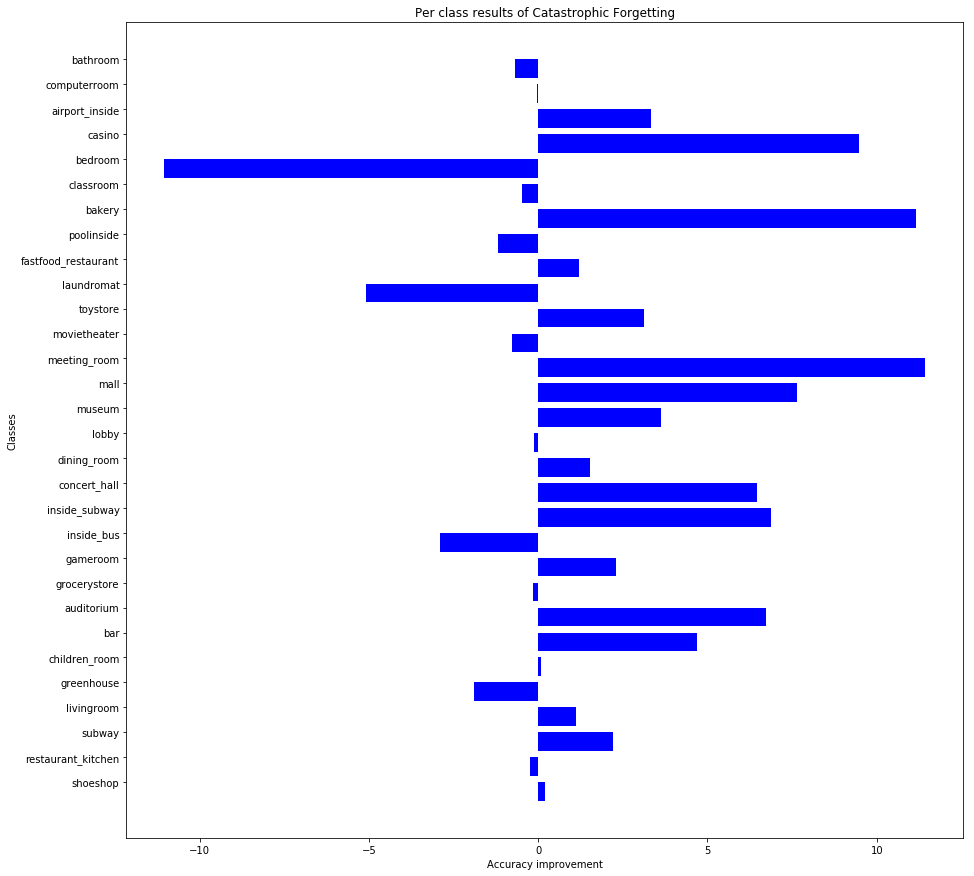

In [6]:
print(np.mean(acc1))
print(np.mean(acc2))
# # print(np.mean(acc1_mean))
# # print(np.mean(acc2_mean))

x = []
y = []
for k, v in per_class_acc.items():
    x.append(k)
    y.append(np.mean(v)*100)
    
    print('%s ----- %f'%(x[-1],y[-1]))


    
fig, ax = plt.subplots(figsize=(15, 15))    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('Per class results of Catastrophic Forgetting')
plt.xlabel('Accuracy improvement')
plt.ylabel('Classes')    
plt.show()


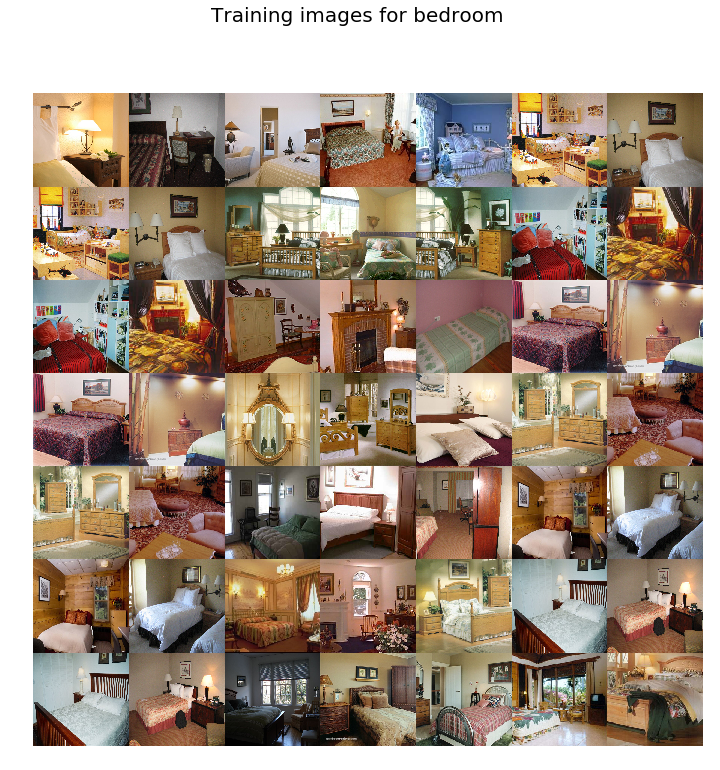

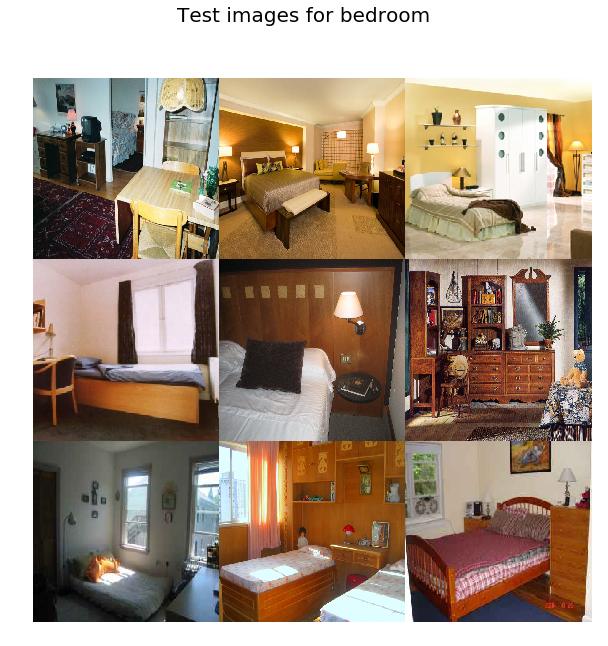

In [9]:
DATA_PATH = '/media/red/capstone/data/mit_67/Images/'
def preview_category(category):
    # Load data from disk
    features, file_names = pickle.load(open(FEATURE_FILE, "rb"))
    train_split = 0.9
    num_samples = int(train_split*len(file_names[category]))
    training_imgs = file_names[category][:num_samples]
    test_imgs = file_names[category][num_samples:]
    
    # Plot training images 
    num_rows = 7
    num_cols = 7
    fig = plt.figure(figsize=(12,12))
    gs = gridspec.GridSpec(num_rows, num_cols, wspace=0.0, hspace=0.0)
    ax = [plt.subplot(gs[i]) for i in range(num_rows*num_cols)]
    for i in range(num_rows):
        for j in range(num_cols):
            img_path = os.path.join(DATA_PATH, category, training_imgs[5*i+j])
            img = misc.imread(img_path)
            ax[i*num_rows+j].imshow(img)
            ax[i*num_rows+j].axis('off')
            ax[i*num_rows+j].set_aspect('auto')
    fig.suptitle('Training images for %s'%(category), size=20)
    plt.show()
    
    # Plot test images
    num_rows = 3
    num_cols = 3
    fig = plt.figure(figsize=(10,10))
    gs = gridspec.GridSpec(num_rows, num_cols, wspace=0.0, hspace=0.0)
    ax = [plt.subplot(gs[i]) for i in range(num_rows*num_cols)]
    for i in range(num_rows):
        for j in range(num_cols):
            img_path = os.path.join(DATA_PATH, category, test_imgs[5*i+j])
            img = misc.imread(img_path)
            ax[i*num_rows+j].imshow(img)
            ax[i*num_rows+j].axis('off')
            ax[i*num_rows+j].set_aspect('auto')
    fig.suptitle('Test images for %s'%(category), size=20)
    plt.show()
    
preview_category('bedroom')
    

## Compositional updates

In [4]:
model = load_model('mit_adam_cosine_100k__lr4_nobn_nonorm_02-0.11.h5')
acc0, acc2 = [], []
per_class_acc = defaultdict(list)

for i in range(200):
    base_class_ind = np.random.permutation(len(splits['base']))[:10]
    base_classes = splits['base'][base_class_ind]
    pos_class = np.random.choice(base_classes)
    
    
    X1 = compute_X1(pos_class, base_classes, features, is_train=True)
    neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))


    new_class1 = np.random.choice(splits['test'])
    neg_classes_extra = np.append(neg_classes, new_class1)    # 9 + 1 classes
    

    # n + 1 update
    X2 = compute_X2(new_class1, base_classes, features, is_train=True)
    X = np.hstack((X1, X2))
    X = np.reshape(X, (1, 8192))
    Y_hat = model.predict(X)
    Y = X1 + Y_hat.reshape((4096))
    
    
    
    # n + 2 update
    new_class2 = np.random.choice(np.delete(splits['test'], np.argwhere(splits['test']==new_class1)))
    neg_classes_extra = np.append(neg_classes, new_class1)
    pos_features_test, neg_features_test = prepare_features(pos_class, 
                                                            neg_classes_extra, 
                                                            features, 
                                                            is_train=False, 
                                                            equal_features=False)
    
    X2 = compute_X2(new_class2, base_classes, features, is_train=True)
    X = np.hstack((Y, X2))
    X = np.reshape(X, (1, 8192))
    Y_hat = model.predict(X)
    Y_2 = Y + Y_hat.reshape((4096))
    
    # Save accuracies
    acc0.append(compute_accuracy(X1, pos_features_test, neg_features_test))
    acc2.append(compute_accuracy(Y_2, pos_features_test, neg_features_test))
    per_class_acc[pos_class].append(acc2[-1] - acc0[-1])
    

    print('%.5f %.5f %0.3f %s|%s + %s' % (acc0[-1],acc2[-1], 100*(acc2[-1]-acc0[-1]), pos_class, new_class1, new_class2)) 

0.94231 0.94231 0.000 shoeshop|prisoncell + florist
0.96364 0.95909 -0.455 poolinside|videostore + office
0.91473 0.93023 1.550 movietheater|clothingstore + laboratorywet
0.88679 0.93208 4.528 auditorium|cloister + bookstore
0.95720 0.95720 0.000 restaurant_kitchen|laboratorywet + kitchen
0.97571 0.92713 -4.858 movietheater|closet + florist
0.81269 0.78550 -2.719 livingroom|clothingstore + restaurant
0.92664 0.93050 0.386 mall|office + clothingstore
0.89542 0.84641 -4.902 dining_room|laboratorywet + bookstore
0.95322 0.94737 -0.585 auditorium|pantry + florist
0.68382 0.91176 22.794 meeting_room|kitchen + office
0.86219 0.85512 -0.707 bakery|studiomusic + office
0.94340 0.89434 -4.906 laundromat|laboratorywet + clothingstore
0.83526 0.82370 -1.156 bar|videostore + kitchen
0.81571 0.81571 0.000 airport_inside|bookstore + nursery
0.89443 0.96774 7.331 concert_hall|cloister + restaurant
0.83544 0.82025 -1.519 livingroom|jewelleryshop + pantry
1.00000 0.98263 -1.737 greenhouse|videostore + 

0.89181 0.86550 -2.632 inside_subway|office + videostore
0.94020 0.94020 0.000 auditorium|studiomusic + clothingstore
0.92059 0.87941 -4.118 bakery|nursery + closet
0.99623 0.95849 -3.774 restaurant_kitchen|locker_room + florist
0.96817 0.94695 -2.122 bathroom|library + restaurant
0.91967 0.92244 0.277 dining_room|restaurant + kitchen
0.90556 0.81389 -9.167 bedroom|restaurant + clothingstore
0.93750 0.93750 0.000 auditorium|bookstore + jewelleryshop
0.94191 0.94606 0.415 shoeshop|library + nursery
0.75329 0.77961 2.632 bedroom|cloister + locker_room
0.96099 0.96099 0.000 lobby|jewelleryshop + office
0.91045 0.91045 0.000 meeting_room|florist + cloister
0.93789 0.95963 2.174 gameroom|restaurant + library
0.96857 0.96857 0.000 concert_hall|locker_room + jewelleryshop
0.77491 0.77491 0.000 bar|videostore + library
0.97009 0.94872 -2.137 shoeshop|videostore + bookstore
0.47059 0.83088 36.029 inside_subway|prisoncell + clothingstore
0.83380 0.96901 13.521 bathroom|kitchen + restaurant
0.975

0.888949089685
0.899685270639
shoeshop ----- -11.283589
poolinside ----- 1.241461
movietheater ----- -2.018930
auditorium ----- 0.159907
restaurant_kitchen ----- 5.003179
livingroom ----- -1.507054
mall ----- 1.778801
dining_room ----- -4.537936
meeting_room ----- 8.136196
bakery ----- -7.087254
laundromat ----- -3.343644
bar ----- 5.819963
airport_inside ----- 1.584586
concert_hall ----- 2.009071
greenhouse ----- -1.689752
computerroom ----- 1.016356
inside_bus ----- 5.306834
casino ----- -1.350498
toystore ----- -4.425224
lobby ----- -0.308793
children_room ----- 6.156904
museum ----- 0.068120
subway ----- 2.430062
fastfood_restaurant ----- 12.307959
classroom ----- 11.235677
bedroom ----- -12.017085
bathroom ----- 4.243257
inside_subway ----- 3.112448
gameroom ----- 2.307709
grocerystore ----- -3.876190


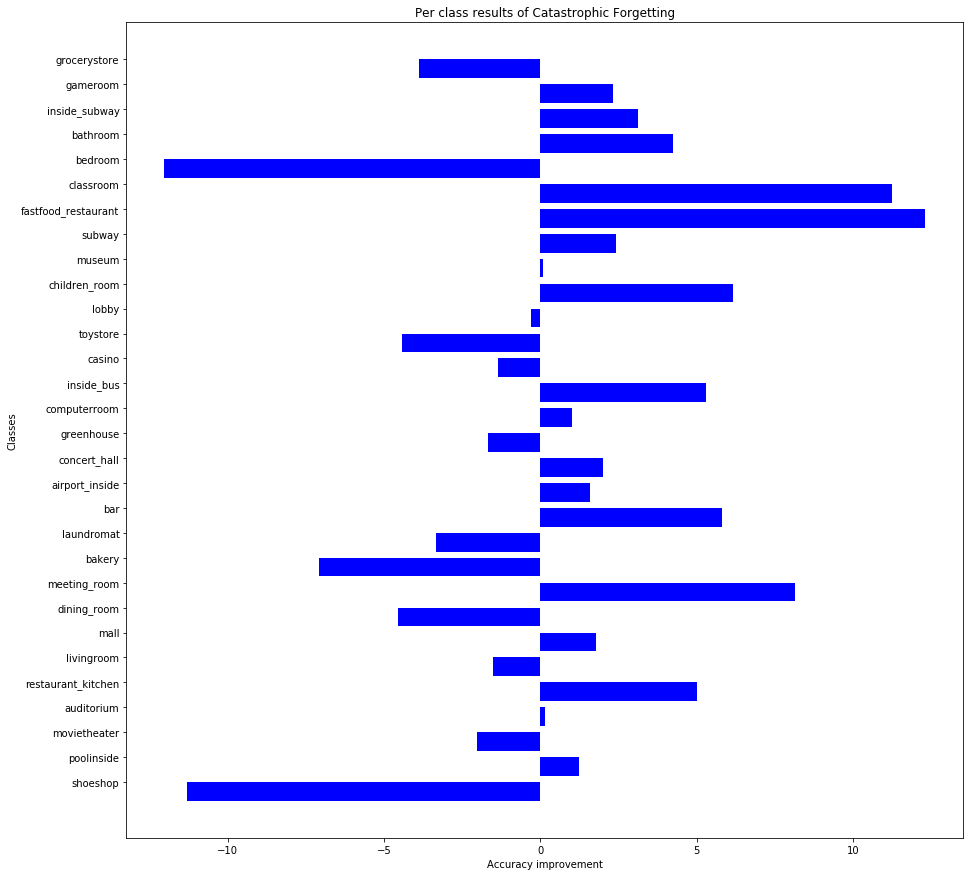

In [5]:
print(np.mean(acc0))
print(np.mean(acc2))


x = []
y = []
for k, v in per_class_acc.items():
    x.append(k)
    y.append(np.mean(v)*100)
    
    print('%s ----- %f'%(x[-1],y[-1]))


    
fig, ax = plt.subplots(figsize=(15, 15))    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('Per class results of Catastrophic Forgetting')
plt.xlabel('Accuracy improvement')
plt.ylabel('Classes')    
plt.show()



